In [1]:
#Import relevant packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import numpy as np
import itertools
from scipy import spatial
import bisect

In [2]:
#Load altitude data
thou0=pd.DataFrame()
tiles=['nh/NH70NE','nh/NH70SE','nn/NN79NE','nn/NN79SE','nn/NN78NE','nn/NN78SE']
for i in tiles:
    thou0=thou0.append(pd.read_csv('Downloads/terrain-5-dtm_3274427/'+i+'.asc',sep=' ',header=None),ignore_index=True)

In [3]:
thou1=pd.DataFrame()
tiles=['nh/NH80NW','nh/NH80SW','nn/NN89NW','nn/NN89SW','nn/NN88NW','nn/NN88SW']
for i in tiles:
    thou1=thou1.append(pd.read_csv('Downloads/terrain-5-dtm_3274427/'+i+'.asc',sep=' ',header=None),ignore_index=True)

In [4]:
thou2=pd.DataFrame()
tiles=['nh/NH80NE','nh/NH80SE','nn/NN89NE','nn/NN89SE','nn/NN88NE','nn/NN88SE']
for i in tiles:
    thou2=thou2.append(pd.read_csv('Downloads/terrain-5-dtm_3274427/'+i+'.asc',sep=' ',header=None),ignore_index=True)

In [5]:
thou3=pd.DataFrame()
tiles=['nh/NH90NW','nh/NH90SW','nn/NN99NW','nn/NN99SW','nn/NN98NW','nn/NN98SW']
for i in tiles:
    thou3=thou3.append(pd.read_csv('Downloads/terrain-5-dtm_3274427/'+i+'.asc',sep=' ',header=None),ignore_index=True)

In [6]:
thou4=pd.DataFrame()
tiles=['nh/NH90NE','nh/NH90SE','nn/NN99NE','nn/NN99SE','nn/NN98NE','nn/NN98SE']
for i in tiles:
    thou4=thou4.append(pd.read_csv('Downloads/terrain-5-dtm_3274427/'+i+'.asc',sep=' ',header=None),ignore_index=True)

In [7]:
#Rename columns
thou0.columns=np.arange(1000)
thou1.columns=np.arange(1000,2000)
thou2.columns=np.arange(2000,3000)
thou3.columns=np.arange(3000,4000)
thou4.columns=np.arange(4000,5000)
#Join the columns
river_feshie=thou0.join(thou1,how='outer').join(thou2,how='outer').join(thou3,how='outer').join(thou4,how='outer')

In [8]:
#Convert to np.array([])
river_feshie=river_feshie.to_numpy()

In [9]:
#Take a look at what we've got
river_feshie

array([[681.25, 681.2 , 680.95, ..., 428.07, 429.55, 431.04],
       [679.87, 679.62, 679.37, ..., 427.94, 429.43, 430.91],
       [678.29, 678.04, 677.8 , ..., 427.82, 429.3 , 430.79],
       ...,
       [834.11, 833.72, 833.33, ..., 563.88, 563.96, 564.04],
       [833.97, 833.58, 833.18, ..., 563.77, 563.85, 563.92],
       [833.83, 833.43, 833.04, ..., 563.66, 563.74, 563.81]])

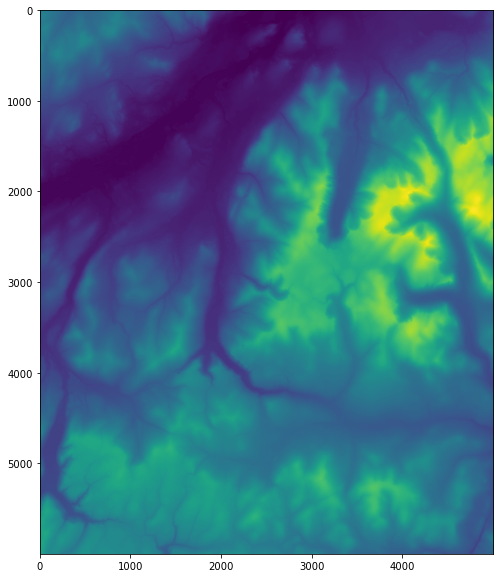

In [10]:
plt.figure(figsize=(12,10))
plt.imshow(river_feshie)

In [11]:
#Load the coords for each altitude tile
alt_coords=geopandas.GeoDataFrame()

In [12]:
tiles=['70NE','70SE','80NW','80NE','80SW','80SE','90NW','90NE','90SW','90SE']
for i in tiles:
    alt_coords=alt_coords.append(geopandas.read_file('Downloads/terrain-5-dtm_3274427/nh/NH'+i+'.gml'))

In [13]:
tiles=['78NE','78SE','79NE','79SE','88NW','88NE','88SW','88SE','89NW','89NE','89SW','89SE','98NW','98NE','98SW','98SE','99NW','99NE','99SW','99SE']
for i in tiles:
    alt_coords=alt_coords.append(geopandas.read_file('Downloads/terrain-5-dtm_3274427/nn/NN'+i+'.gml'))

In [14]:
#Reindex
alt_coords.index=np.arange(alt_coords.shape[0])
#Assign coordinate system- https://digimap.edina.ac.uk/roam/map/os > Map Information > Map Projection
#Luckily this is the same as the river data
alt_coords.crs={'init':'epsg:27700'}
alt_coords=alt_coords.geometry
alt_coords=np.transpose(np.array([list(x.coords) for x in alt_coords]).reshape(30,2))

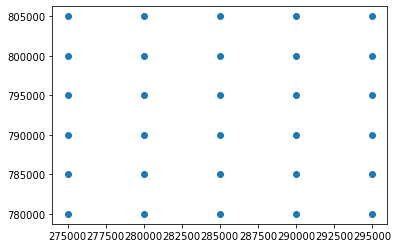

In [15]:
#Create plot to examine range of coordinates
plt.scatter(alt_coords[0],alt_coords[1])

In [16]:
#Load the river data
nwater=geopandas.read_file('Downloads/vml_3309318/nn/nn88ne.gml')
nn=['88nw','88se','88sw','89nw','89ne','89sw','89se','98nw','98sw','99sw']
for nn in nn:
    nwater.append(geopandas.read_file('Downloads/vml_3309318/nn/nn'+nn+'.gml'))
#Extract the water feature geometry
nwater=nwater[nwater['featureDescription']=='Water Feature'].geometry
#Reindex
nwater.index=np.arange(len(nwater))

In [17]:
#Extract the river (the longest LineString)
line_water=geopandas.GeoSeries(nwater[np.argmax([len(nwater[x].coords[:]) for x in range(len(nwater))])])

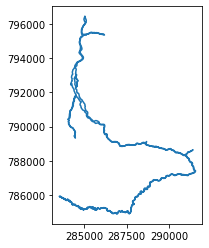

In [18]:
line_water.plot()

In [19]:
line_water

0    LINESTRING (285074.360 796370.320, 285090.900 ...
dtype: geometry

In [20]:
#Extract unique coords
water_coords=np.transpose(np.unique(np.array(list(itertools.chain(*[list(x.coords) for x in line_water]))),axis=0))
pseudo_lats=water_coords[1]
pseudo_longs=water_coords[0]

In [22]:
#Create np.array() of the [row,column] indexers of all the altitudes of the river, by comparing river coordinates to altitude coordinates
#Obtain np.arange() by eyeballing above plot, assuming each point is the bottom left of its tile
#Find the closest coordinate points for each point in the river
river_array=np.array([[bisect.bisect(np.arange(780000,810005,5),x) for x in pseudo_lats],
                     [bisect.bisect(np.arange(275000,300000,5),x) for x in pseudo_longs]])
#Drop duplicate coordinates
river_array=np.unique(np.transpose(river_array),axis=0)
#Create transposed version as well
river_array_T=np.transpose(river_array)

In [23]:
#Flip altitude data to match the river
river_feshie=np.flip(river_feshie,axis=0)

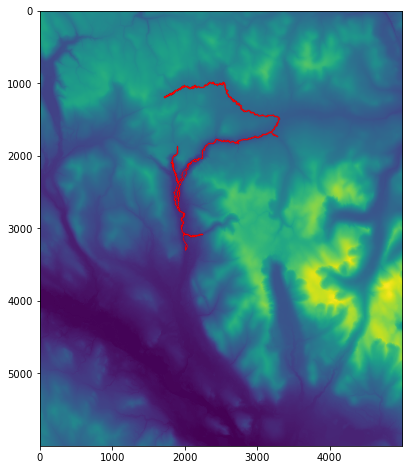

In [24]:
#Check the assumption that each original altitude coordinate referred to the bottom left corner of the tile
plt.figure(figsize=(8,8))
plt.imshow(river_feshie)
plt.scatter(river_array_T[1],river_array_T[0],s=.01,c='Red')

In [25]:
#Noice

In [26]:
#Remove now irrelevant altitude data
#Print boundaries around the river data for 
#Rows
print(np.min(river_array_T[0])-500)
print(np.max(river_array_T[0])+500)
#Columns
print(np.min(river_array_T[1])-500)
print(np.max(river_array_T[1])+500)

479
3792
1211
3805


In [27]:
#Delete irrelevant data
river_feshie=river_feshie[479:3792,1211:3805]

In [28]:
#Change positions of river to match
river_array_T=np.array([river_array_T[0]-(np.min(river_array_T[0])-500),river_array_T[1]-(np.min(river_array_T[1])-500)])
river_array=np.transpose(river_array_T)

Text(0.5, 1.0, 'River location on altitude heatmap')

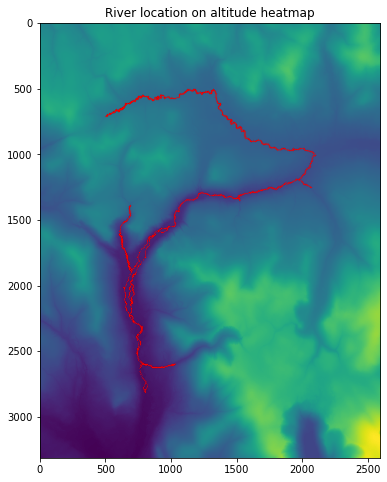

In [124]:
#Double check
plt.figure(figsize=(8,8))
plt.imshow(river_feshie)
plt.scatter(river_array_T[1],river_array_T[0],s=.01,c='Red')
plt.title('River location on altitude heatmap')

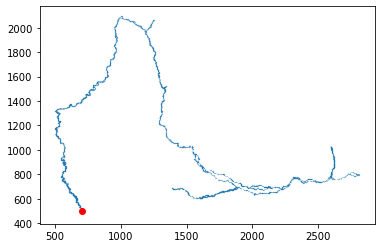

In [30]:
x,y=zip(*river_array)
plt.scatter(x,y,s=.01)
plt.scatter(706,500,c='r')

In [140]:
tree=spatial.cKDTree(river_array)
ordered_coords=[[706,500],[705,500]]
for i in ordered_coords:
    index=tree.query(i,k=[2])[1]
    if river_array[index].flatten().tolist() not in ordered_coords:
        ordered_coords.append(river_array[index].flatten().tolist())
    else:
        k=3
        while river_array[index].flatten().tolist() in ordered_coords:
            k+=1
            index=tree.query(i,k=[k])[1]
        ordered_coords.append(river_array[index].flatten().tolist())

IndexError: index 5440 is out of bounds for axis 0 with size 5440

In [152]:
tree=spatial.cKDTree(river_array)
ordered_coords=[[706,500],[705,500]]
river_list=river_array.tolist()
for i in ordered_coords:
    point=river_list[tree.query(i,k=[2])[1][0]]
    if point not in ordered_coords:
        ordered_coords.append(point)
    else:
        k=3
        while point in ordered_coords:
            k+=1
            index=tree.query(i,k=[k])[1]
        ordered_coords.append(point)
    print(ordered_coords[-1])

KeyboardInterrupt: 

In [153]:
ordered_coords

[[706, 500], [705, 500]]

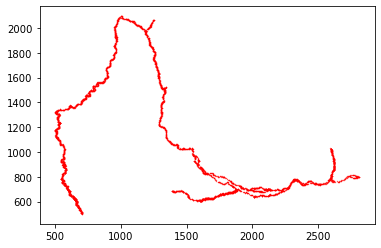

In [159]:
x,y=zip(*ordered_coords[:1500])
plt.plot(x,y)
xr,yr=zip(*river_array)
plt.scatter(xr,yr,s=.1,c='r')

Text(0.5, 1.0, 'Altitude vs Horizontal Distance')

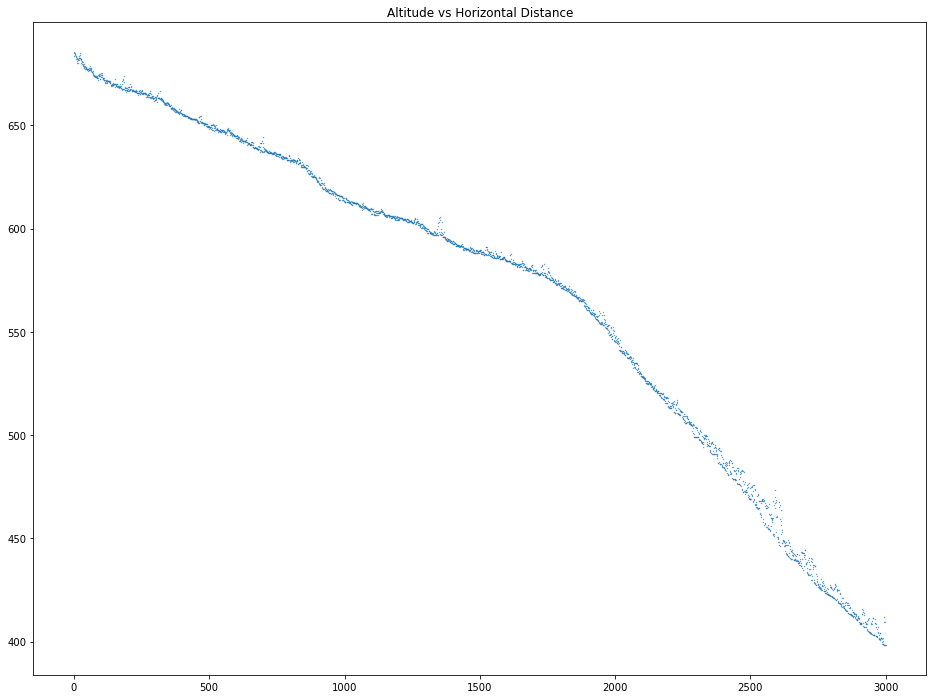

In [136]:
plt.figure(figsize=(16,12))
plt.scatter(list(range(3000)),[river_feshie[i[0]][i[1]] for i in ordered_coords[:3000]],s=.1)
plt.title('Altitude vs Horizontal Distance')

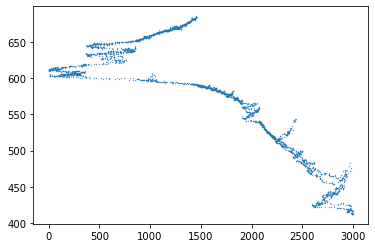

In [160]:
plt.scatter(list(range(3000)),[river_feshie[i[0],i[1]] for i in river_array[:3000]],s=.1)

In [22]:
#Create np.array() of the difference in altitude between each point and the closest point in the river
array=np.array([[[i,j] for j in range(len(river_feshie[0]))] 
                for i in range(len(river_feshie))])
array=array.reshape(8593922,2)

In [23]:
#Create np.array() of the closest point in the river for each altitude point
closest=np.array([river_array[x] for x in spatial.cKDTree(river_array).query(array)[1]])

In [24]:
#Create empty np.array()
alt_diffs=np.zeros((3313,2594))

In [25]:
#Assign to each point in the empty np.array the difference in altitude between itself and the nearest point in the river
for i in range(8593922):
    alt_diffs[array[i][0]][array[i][1]]=river_feshie[array[i][0]][array[i][1]]-river_feshie[closest[i][0]][closest[i][1]]

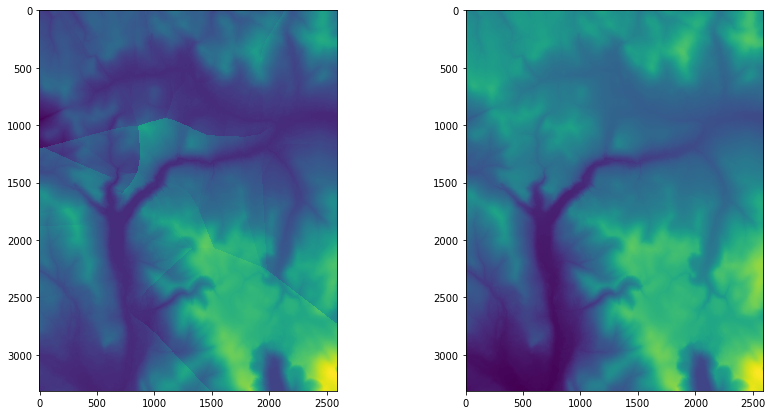

In [26]:
#Compare to original altitude data
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.imshow(alt_diffs)
plt.subplot(122)
plt.imshow(river_feshie)

In [27]:
#Double check that the altitude difference in the river is zero
for i in range(len(river_array)):
    print(alt_diffs[closest[i][0]][closest[i][1]])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


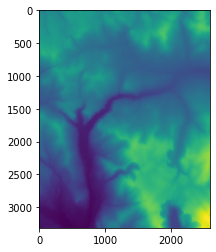

In [212]:
plt.imshow(river_feshie)

In [41]:
#Import relevant packages
from skimage import data
from skimage.filters import sobel, threshold_otsu
from skimage.color import rgb2gray, label2rgb
from skimage import exposure
from skimage.transform import rotate, rescale, resize
from skimage.restoration import inpaint, denoise_tv_chambolle, denoise_bilateral
from skimage.util import random_noise
from skimage.segmentation import slic
from skimage import measure
#from skimage.feature import canny, corner_harris, corner_peaksQ

In [2]:
#Store each video frame as numpy array
import cv2
cap = cv2.VideoCapture('Downloads/DSCF0001.AVI')
count = 0
frame_dict={}
while (cap.isOpened()):
    ret, frame = cap.read() #Why is this necessary??
    if ret == True:
        frame_dict['frame'+str(count)]=frame
        count += 1
    else:
        break

In [4]:
#Crop down to that one rock
for i in range(54):
    frame_dict['frame'+str(i)]=frame_dict['frame'+str(i)][750:1250,200:1000]

In [5]:
#{frame_dict['frame'+str(i)][750:1250,200:1000] for i in range(54)}

In [8]:
np.transpose(np.array([river_pic[:,:,0],river_pic[:,:,1],river_pic[:,:,2]])*255).astype('uint8')

NameError: name 'river_pic' is not defined

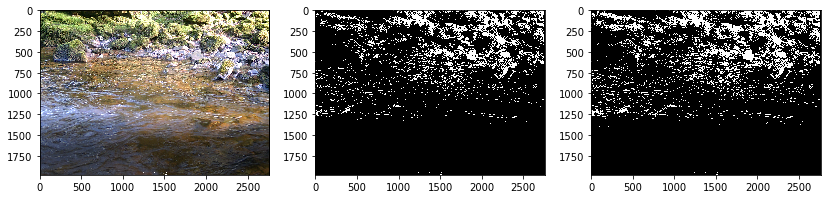

In [23]:
river_pic=plt.imread('Downloads/Capture.PNG')
plt.figure(figsize=(14,14))
plt.subplot(131)
plt.imshow(river_pic)
plt.subplot(132)
plt.imshow(rgb2gray(river_pic)<=.75,cmap='Greys')
plt.subplot(133)
plt.imshow(river_pic[:,:,1]<.7,cmap='Greys')

In [47]:
river_pic=plt.imread('Downloads/Capture.PNG')

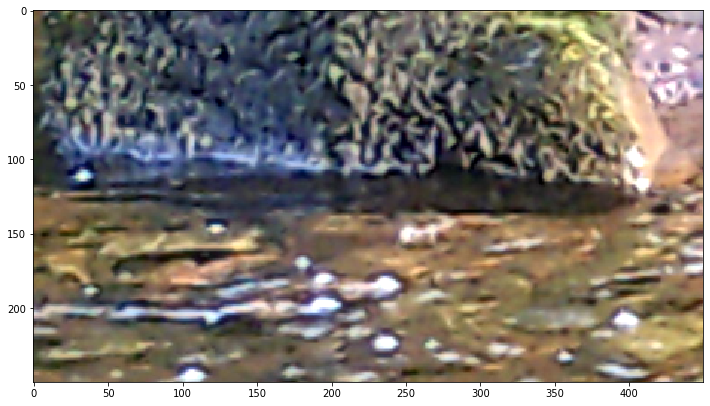

In [48]:
plt.figure(figsize=(12,12))
plt.imshow(river_pic[500:750,150:600])

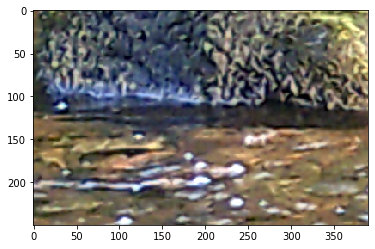

In [49]:
river_pic=river_pic[500:750,150:540]
plt.imshow(river_pic)

In [98]:
river_pic=plt.imread('Downloads/Capture.PNG')
river_pic=river_pic[500:750,150:540]
river_pic=np.transpose(np.array([river_pic[:,:,0],river_pic[:,:,1],river_pic[:,:,2]])*255).astype('uint8')

In [97]:
#plt.imshow(rgb2gray(river_pic),cmap='Greys')
gray_river=river_pic#(rgb2gray(river_pic)*255).astype('uint8')
plt.imshow(label2rgb(slic(gray_river,n_segments=9),gray_river,kind='avg'))


ValueError: Buffer dtype mismatch, expected 'double' but got 'float'

In [95]:
gray_river

array([[ 94,  91,  92, ..., 117, 113, 112],
       [ 91,  90,  90, ..., 110, 109, 108],
       [ 90,  90,  88, ..., 107, 106, 106],
       ...,
       [226, 205, 170, ...,  85,  92,  98],
       [225, 208, 181, ...,  93,  96,  96],
       [221, 211, 195, ...,  97,  96,  94]], dtype=uint8)

In [51]:
segment_river=label2rgb(slic(river_pic,n_segments=9),river_pic,kind='avg')

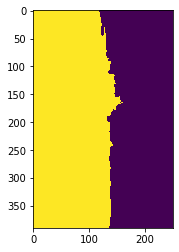

In [73]:
gray_river=rgb2gray(segment_river)
plt.imshow(gray_river<.4)

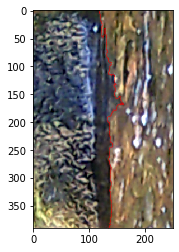

In [76]:
contours=np.transpose(measure.find_contours(gray_river<.4,0.8))
plt.scatter(contours[1],contours[0],s=.01,c='R')
plt.imshow(river_pic)

In [116]:
#Store each video frame as numpy array
import cv2
cap = cv2.VideoCapture('Downloads/DSCF0001.AVI')
count = 0
frame_dict={}
while (cap.isOpened()):
    ret, frame = cap.read() #Why is this necessary??
    if ret == True:
        frame_dict['frame'+str(count)]=frame
        count += 1
    else:
        break

In [117]:
#Crop down to that one rock
for i in range(54):
    frame_dict['frame'+str(i)]=frame_dict['frame'+str(i)][750:1250,200:1000]

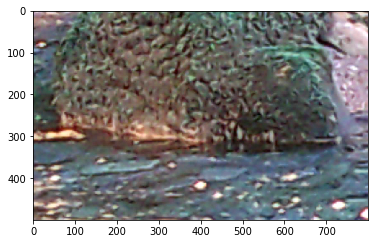

In [118]:
plt.imshow(frame_dict['frame15'])

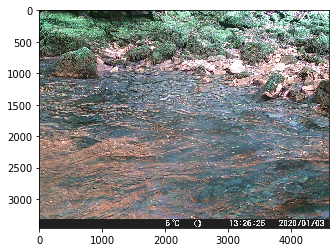

In [39]:
import matplotlib.pyplot as plt
plt.imshow(frame_dict['frame12'])
#plt.show()

matplotlib.image.AxesImage

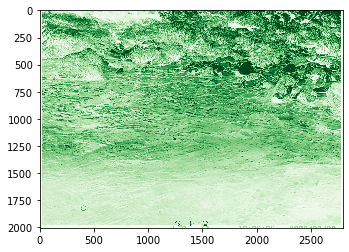

In [210]:
green_river=plt.imread('Downloads/green_river.PNG')
#plt.figure()
type(plt.imshow(green_river[:,:,1],cmap='Greens'))
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(bright_river)
plt.subplot(122)
plt.imshow(denoise_tv_chambolle(bright_river,multichannel=True,weight=1))

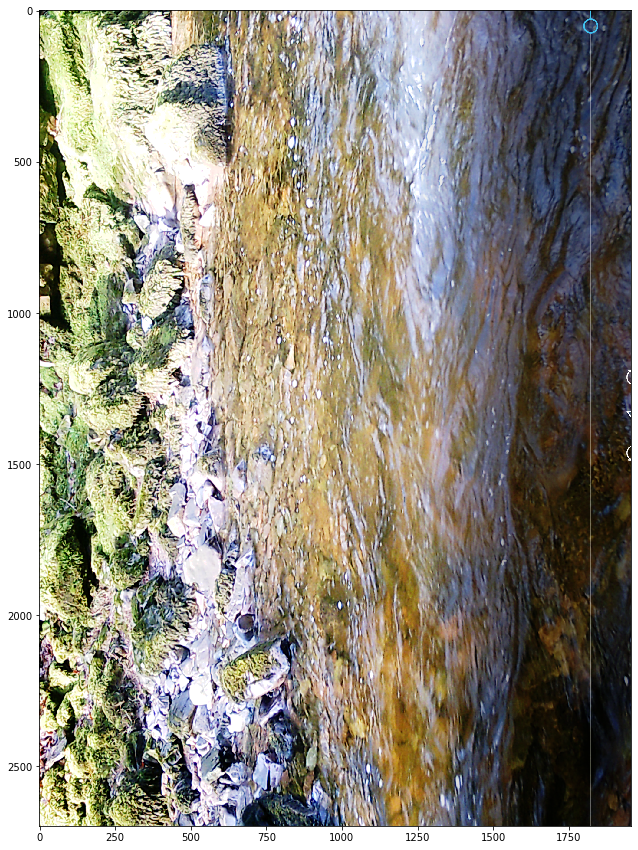

In [257]:
plt.figure(figsize=(15,15))
plt.imshow(exposure.equalize_hist(bright_river))

In [2]:
bright_river=plt.imread('Downloads/bright_river.PNG')
bright_river=(np.transpose(np.array([bright_river[:,:,0],bright_river[:,:,1],bright_river[:,:,2]]))*255).astype('uint8')
segment_river=label2rgb(slic(bright_river,n_segments=47),bright_river,kind='avg')
plt.imshow(segment_river)#[:,:,1])#<146,cmap='Greys')


NameError: name 'plt' is not defined

In [1]:
bright_river

NameError: name 'bright_river' is not defined

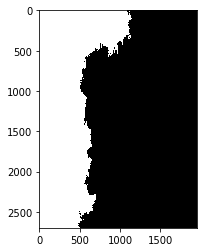

In [279]:
plt.imshow(segment_river[:,:,1]<152,cmap='Greys')

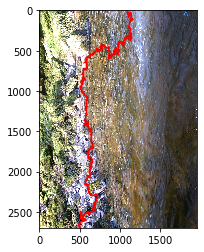

In [280]:
contours=np.transpose(measure.find_contours(segment_river[:,:,1]<152,0.8))
plt.scatter(contours[1],contours[0],s=.01,c='R')
#plt.imshow((segment_river)[:,:,1]<152,cmap='Greys')
plt.imshow(bright_river)

ValueError: x and y must be the same size

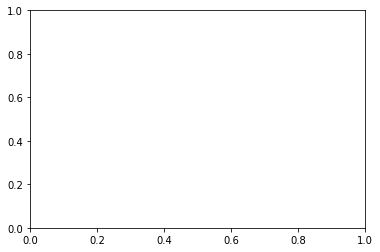

In [6]:
river_pic=(np.transpose(np.array([river_pic[:,:,0],river_pic[:,:,1],river_pic[:,:,2]]))*255).astype('uint8')
segment_river=label2rgb(slic(river_pic,n_segments=47),river_pic,kind='avg')
contours=np.transpose(measure.find_contours(segment_river[:,:,1]<152,0.8))
plt.scatter(contours[1],contours[0],s=.01,c='R')
plt.imshow(river_pic)

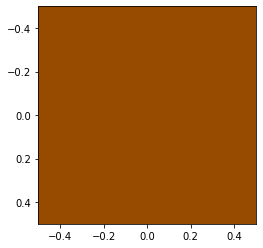

In [19]:
plt.imshow(np.array([[[150,75,0]]]))

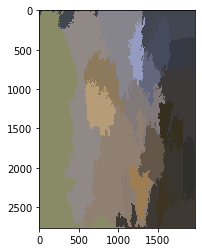

In [20]:
plt.imshow(segment_river)#[:,:,1]-(segment_river[:,:,0]+segment_river[:,:,2]))

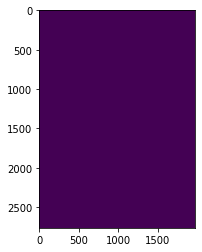

In [31]:
bool_river=(segment_river[:,:,0]/segment_river[:,:,1]>.4)&(segment_river[:,:,0]/segment_river[:,:,1]<.6)
plt.imshow(bool_river.astype('int')*255)

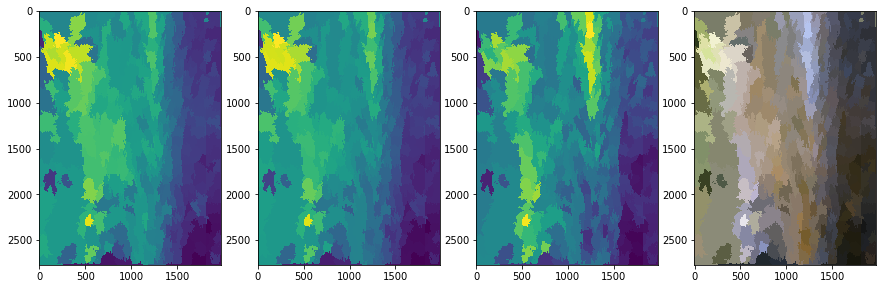

In [131]:
plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(segment_river[:,:,0])
plt.subplot(142)
plt.imshow(segment_river[:,:,1])
plt.subplot(143)
plt.imshow(segment_river[:,:,2])
plt.subplot(144)
plt.imshow(segment_river)

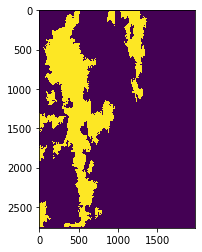

In [166]:
plt.imshow(exposure.equalize_hist(segment_river[:,:,1])>.8)

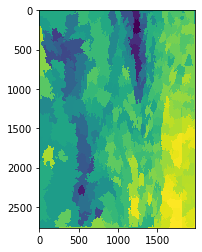

In [140]:
plt.imshow(segment_river[:,:,0]-(segment_river[:,:,2]+segment_river[:,:,1]))#+segment_river[:,:,2]))

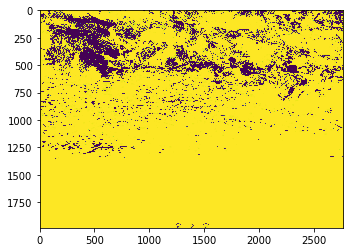

In [160]:
plt.imshow(denoise_tv_chambolle(rgb2gray(bright_river)<.8))

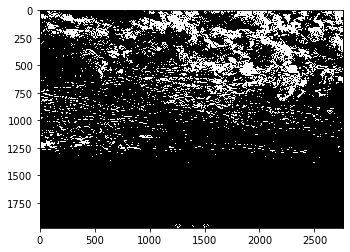

In [184]:
plt.imshow(rgb2gray(river_pic)<=.75,cmap='Greys')
plt.imshow(river_pic[:,:,1]<.7,cmap='Greys')

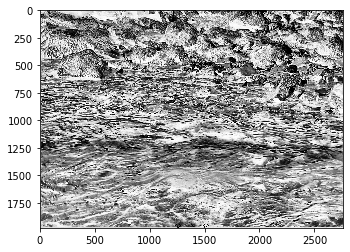

In [133]:
plt.imshow(exposure.equalize_adapthist(rgb2gray(river_pic),clip_limit=.03),cmap='Greys')

In [138]:
thresh=.5
binary=river_pic>thresh
plt.imshow(binary)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000021EB8EC1D90> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

In [142]:

river_pic=(rgb2gray(river_pic))
#plt.imshow(river_pic[river_pic>127])

In [135]:
plt.imshow(threshold(river_pic))

NameError: name 'threshold' is not defined

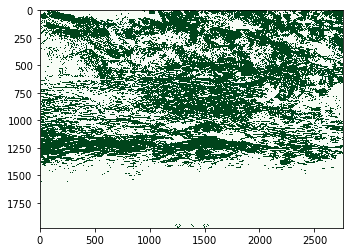

In [109]:

plt.imshow(river_pic[:,:,1]>threshold_otsu(river_pic[:,:,1]),cmap='Greens')

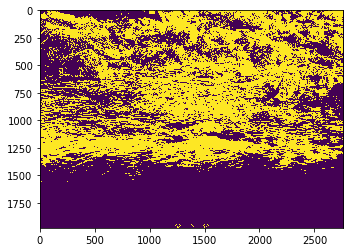

In [143]:
river_pic>.

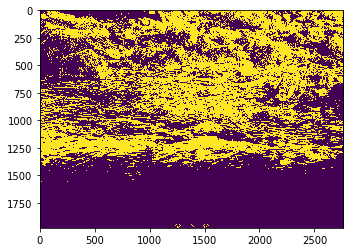

In [145]:
plt.imshow(river_pic>0.5)

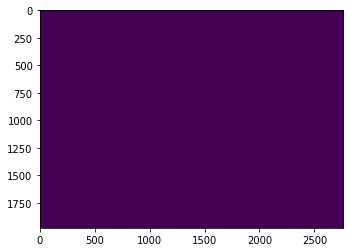

In [113]:
plt.imshow(river_pic[:,:,0]==51)

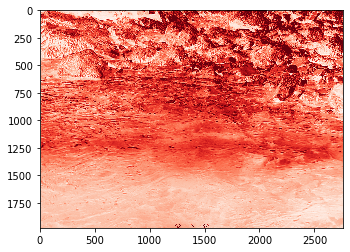

In [85]:
plt.imshow(river_pic[:,:,0],cmap='Reds')

In [78]:
from skimage.filters import threshold_otsu
plt.imshow(np.array(river_pic)>127)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000021EB8EC1D90> (for post_execute):


ValueError: Unsupported dtype

ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

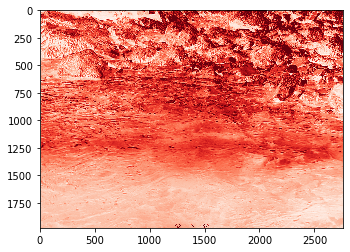

In [74]:
plt.imshow(np.transpose(np.transpose(np.array(river_pic))[0]),cmap='Reds')

ValueError: Colormap grayscale is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

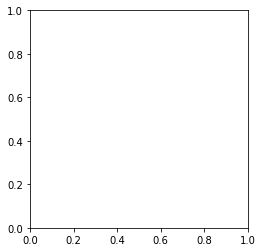

In [57]:
plt.imshow(np.transpose(np.array(river_pic.getdata()).reshape(river_pic.size[1], river_pic.size[0], 4))[0],cmap='grayscale')

In [ ]:
##Make sure not to put seismometer in a tributary

In [ ]:
##WHAT I'VE LEARNED
#np.linspace()
#np.transpose()
#pd.DataFrame.interpolate()
#np.unique()
#xarray.Dataset()
#ax.annotate()
#np.hypot()
#bisect.bisect()
#list comprehension
#sns.scatterplot()
#itertools.chain()
#sns.heatmap()
#pd.DataFrame().reset_index
#pd.DataFrame().sort_index
#pd.DataFrame().join()
#np.delete()

In [ ]:
##RANKING OF PYTHON PACKAGES
#numpy
#pandas
#xarray
#seaborn









#matplotlib


In [156]:
5+4


9

In [157]:
_*20

180

In [158]:
__*9

81